In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"using PyTorch version: {torch.__version__}, Device: {DEVICE}")

using PyTorch version: 2.1.0+cu121, Device: cuda


In [3]:
train_dataset = datasets.MNIST(root='MNIST_data/', train=True, download=True,
                               transform=transforms.ToTensor())

test_dataset = datasets.MNIST(root='MNIST_data/', train=False, download=True,
                              transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 116410315.18it/s]


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 14960564.88it/s]


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32769747.67it/s]


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24455107.53it/s]


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [4]:
print(len(train_dataset))

train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)

train_dataset, validation_dataset = random_split(train_dataset, [train_dataset_size, validation_dataset_size])

print(len(train_dataset), len(validation_dataset), len(test_dataset))

60000
51000 9000 10000


In [5]:
BATCH_SIZE = 64

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
class MyCNNModel(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)

    def forward(self, data):

        data = self.conv1(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = self.conv2(data)
        data = torch.relu(data)
        data = self.pooling(data)
        data = self.dropout25(data)

        data = data.view(-1, 7 * 7 * 64)

        data = self.fc1(data)
        data = torch.relu(data)
        data = self.dropout50(data)

        logits = self.fc2(data)

        return logits

In [7]:
model = MyCNNModel().to(DEVICE)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [8]:
def model_train(dataloader, model, loss_function, optimizer):

    model.train()

    train_loss_sum = train_correct = train_total = 0

    total_train_batch = len(dataloader)

    for images, labels in dataloader:

        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        outputs = model(x_train)
        loss = loss_function(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()

        train_total += y_train.size(0)
        train_correct += ((torch.argmax(outputs, 1)==y_train)).sum().item()

    train_avg_loss = train_loss_sum / total_train_batch
    train_avg_accuracy = 100*train_correct / train_total

    return (train_avg_loss, train_avg_accuracy)

In [9]:
def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval()

    with torch.no_grad():

        val_loss_sum = val_correct = val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader:

            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch
        val_avg_accuracy = 100*val_correct / val_total

    return (val_avg_loss, val_avg_accuracy)

In [10]:
def model_test(dataloader, model):

    model.eval()

    with torch.no_grad():

        test_loss_sum = test_correct = test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader:

            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item()

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

In [11]:
from datetime import datetime

train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):

    #==============  model train  ================
    train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)

    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)
    #=============================================

    #============  model evaluation  ==============
    val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)

    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)
    #============  model evaluation  ==============

    print('epoch:', '%02d' % (epoch + 1),
          'train loss =', '{:.3f}'.format(train_avg_loss), 'train acc =', '{:.3f}'.format(train_avg_accuracy),
          'val loss =', '{:.3f}'.format(val_avg_loss), 'val acc =', '{:.3f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time => ', end_time-start_time)

epoch: 01 train loss = 0.290 train acc = 90.967 val loss = 0.070 val acc = 97.967
epoch: 02 train loss = 0.101 train acc = 96.965 val loss = 0.047 val acc = 98.578
epoch: 03 train loss = 0.075 train acc = 97.643 val loss = 0.038 val acc = 98.844
epoch: 04 train loss = 0.063 train acc = 98.137 val loss = 0.036 val acc = 98.889
epoch: 05 train loss = 0.053 train acc = 98.324 val loss = 0.033 val acc = 98.978
epoch: 06 train loss = 0.051 train acc = 98.439 val loss = 0.030 val acc = 99.011
epoch: 07 train loss = 0.045 train acc = 98.625 val loss = 0.030 val acc = 99.000
epoch: 08 train loss = 0.040 train acc = 98.778 val loss = 0.030 val acc = 99.033
epoch: 09 train loss = 0.038 train acc = 98.800 val loss = 0.028 val acc = 99.178
epoch: 10 train loss = 0.033 train acc = 98.988 val loss = 0.033 val acc = 98.989
epoch: 11 train loss = 0.033 train acc = 99.002 val loss = 0.031 val acc = 99.044
epoch: 12 train loss = 0.031 train acc = 99.022 val loss = 0.032 val acc = 99.078
epoch: 13 train 

In [12]:
# test dataset 으로 정확도 및 오차 테스트

model_test(test_dataset_loader, model)

accuracy: 99.49
loss: 0.018954667667684052


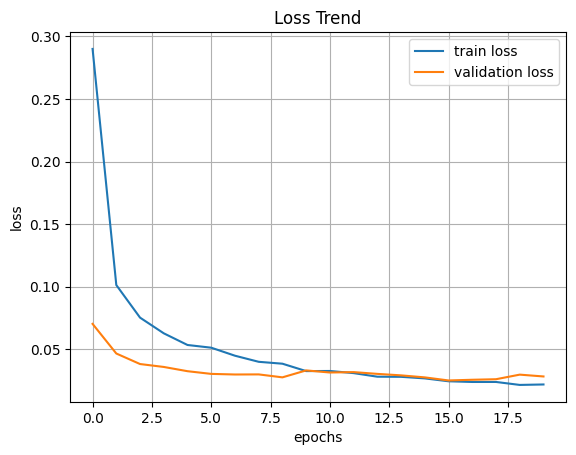

In [13]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()

plt.show()

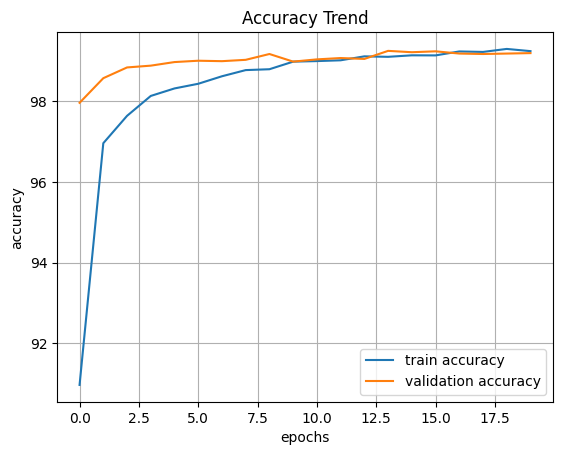

In [14]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()

plt.show()

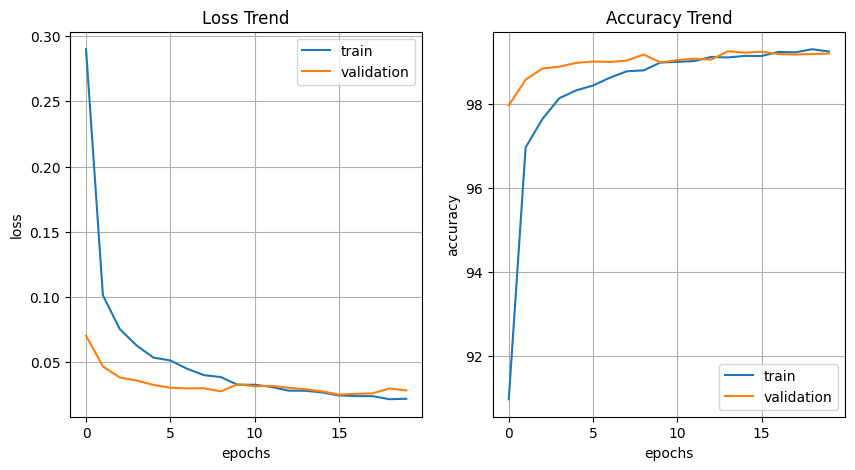

In [15]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()